In [2]:
import random
from queue import PriorityQueue
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
ARRIVAL = 5.0  # Fixed average inter-arrival time
SERVICE = 10.0 #avg service time per server 
SIM_TIME = 500000  # Total simulation time
SERVICE_VALUES = [i for i in range(5, 41, 2)]  # Average service times: 5.0 to 40.0 in steps of 2
TYPE1 = 1
SEED = 123 #fixed seed here 
BUFFER_SIZE = 10 #fixed buffer size - shared buffer for both servers

In [4]:
class Measure:
    def __init__(self, arr=0, dep=0, ut=0, oldT=0, delay=0):
        self.arr = arr
        self.dep = dep
        self.ut = ut
        self.oldT = oldT
        self.delay = delay
        self.bs1 = 0 # busy time for server 1
        self.bs2 = 0 # busy time for server 2
        self.loss = 0 # loss count

    


In [5]:
class Client:
    def __init__(self, type, arrival_time):
        self.type = type
        self.arrival_time = arrival_time


Utilization = Total busy time / Total simulation time × Number of servers

​


In [7]:
def run_simulation(num_servers):
    global users, data, MM1, busy1, busy2
    users = 0
    data = Measure(0, 0, 0, 0, 0)
    MM1 = []
    time = 0
    FES = PriorityQueue() 
    busy1 = False
    busy2 = False

    def arrival(current_time):
        global users, busy1, busy2 
        data.arr += 1
        data.ut += users * (current_time - data.oldT)
        data.oldT = current_time

        inter_arrival = random.expovariate(1.0 / ARRIVAL) #exponential dist 
        FES.put((current_time + inter_arrival, "arrival"))

        if users < BUFFER_SIZE:
            users += 1
            client = Client(TYPE1, current_time)
            MM1.append(client)
            if num_servers == 1:
                if not busy1:
                    service_time = random.expovariate(1/SERVICE)
                    data.bs1 += service_time
                    FES.put((current_time + service_time, "departure1"))
                    busy1 = True
            else:
                if not busy1:
                    service_time = random.expovariate(1/SERVICE)
                    data.bs1 += service_time
                    FES.put((current_time + service_time, "departure1"))
                    busy1 = True
                elif not busy2:
                    service_time = random.expovariate(1/SERVICE)
                    data.bs2 += service_time
                    FES.put((current_time + service_time, "departure2"))
                    busy2 = True
        else:
            data.loss += 1


    def departure(current_time, server_id):
        global users, busy1, busy2

        # if the queue is empty, just mark the server as idle and exit 
        if len(MM1) == 0:
            if server_id == 1:
                busy1 = False
            else:
                busy2 = False
            return
        # normal departure processing
        data.dep += 1
        data.ut += users * (current_time - data.oldT)
        data.oldT = current_time

        client = MM1.pop(0)
        data.delay += (current_time - client.arrival_time)
        users -= 1

        # check if there are more clients in the queue
        if users > 0:
            service_time = random.expovariate(SERVICE)
            if server_id == 1:
                data.bs1 += service_time
                FES.put((current_time + service_time, "departure1"))
            else:
                data.bs2 += service_time
                FES.put((current_time + service_time, "departure2"))
        else:
            if server_id == 1:
                busy1 = False
            else:
                busy2 = False

    random.seed(SEED)
    FES.put((0.0, "arrival"))
    while time < SIM_TIME:
        time, event_type = FES.get()
        if event_type == "arrival":
            arrival(time)
        elif event_type == "departure1":
            departure(time,1)
        elif event_type == "departure2":
            departure(time,2)

    avg_delay = data.delay / data.dep if data.dep > 0 else 0
    avg_users = data.ut / time
    utilization = (data.bs1 + data.bs2) / ( time * num_servers) if num_servers > 0 else 0
    loss_rate = data.loss / data.arr  if data.arr  > 0 else 0
    return avg_delay, avg_users, utilization,loss_rate

single_results = run_simulation(num_servers=1)
multi_results = run_simulation(num_servers=2)

   

In [8]:
print("\nTask 2.a - Single-server Results:")
print("Avg Delay:", round(single_results[0], 4))
print("Avg Users:", round(single_results[1], 4))
print("Utilization:", round(single_results[2], 4))
print("Loss Rate:", round(single_results[3], 4))


Task 2.a - Single-server Results:
Avg Delay: 10.0144
Avg Users: 1.9647
Utilization: 0.6689
Loss Rate: 0.0167


In [9]:

print("\nTask 2.a - Multi-server Results (Shared Buffer):")
print("Avg Delay:", round(multi_results[0], 4))
print("Avg Users:", round(multi_results[1], 4))
print("Utilization:", round(multi_results[2], 4))
print("Loss Rate:", round(multi_results[3], 4))


Task 2.a - Multi-server Results (Shared Buffer):
Avg Delay: 5.4001
Avg Users: 1.0746
Utilization: 0.6003
Loss Rate: 0.0011


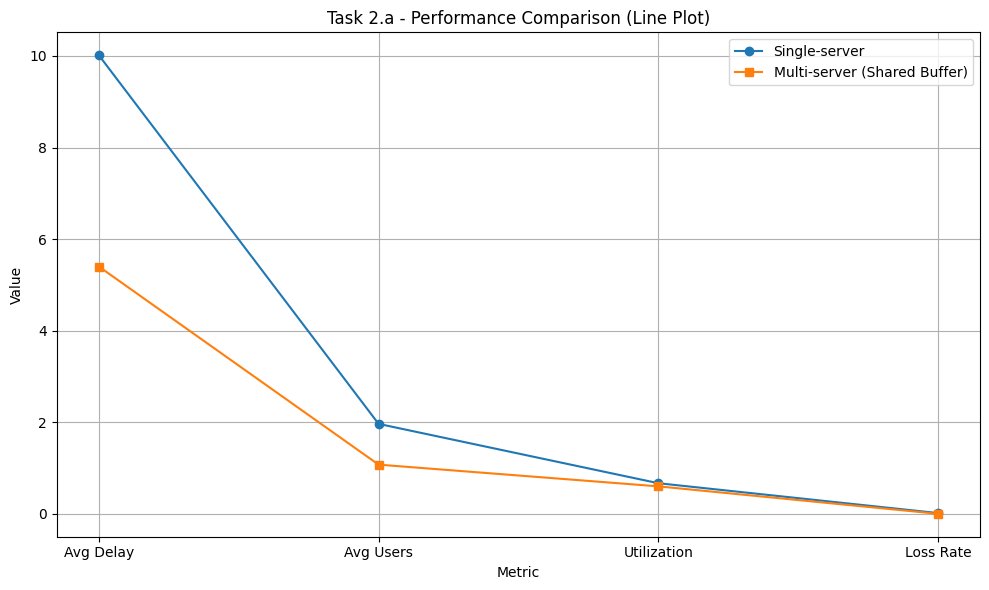

In [10]:
labels = ['Avg Delay', 'Avg Users', 'Utilization', 'Loss Rate']
single = np.array([single_results[0], single_results[1], single_results[2], single_results[3]])
multi = np.array([multi_results[0], multi_results[1], multi_results[2], multi_results[3]])

plt.figure(figsize=(10, 6))
plt.plot(labels, single, marker='o', label='Single-server')
plt.plot(labels, multi, marker='s', label='Multi-server (Shared Buffer)')
plt.title('Task 2.a - Performance Comparison (Line Plot)')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()